### Prerequisites

Installing `tflite` as we are converting TFLite model.

In [ ]:
!pip install tflite

Importing all required modules: tflite, tvm, autotvm, and opencv2

In [53]:
import cv2
import logging
import multiprocessing
import numpy as np
import os
import sys
import tflite
import tvm
import tvm.testing

from matplotlib import pyplot as plt

from tvm import autotvm
from tvm import relay
from tvm import te
from tvm import transform
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner
from tvm.contrib import graph_executor
from tvm.driver import tvmc

Define variable visible to the entire notebook: compilation target.

In [2]:
target = "llvm -mcpu=core-avx2"

### Convert TF Lite model to TVM model and fix layout for tuning

In [3]:
tflite_model_buf = open('selfie_multiclass_256x256.tflite', "rb").read()
tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)

In [4]:
input_tensor = "input_29"
input_shape = (1, 256, 256, 3)
input_dtype = "float32"

mod, params = relay.frontend.from_tflite(
    tflite_model, shape_dict = {input_tensor: input_shape }, dtype_dict={input_tensor: input_dtype}
)

In [5]:
with tvm.transform.PassContext(opt_level=3):
    mod_nchw = tvm.relay.transform.InferType()(mod)
    mod_nchw = tvm.relay.transform.ConvertLayout({"nn.conv2d": ["NCHW", "OIHW"],
                                                  "image.resize2d": ["NCHW"],
                                                  "nn.conv2d_transpose": ["NCHW", "OIHW"]})(mod_nchw)

In [6]:
# Build the module against to x86 CPU
with transform.PassContext(opt_level=3):
    lib = relay.build(mod_nchw, target, params=params)

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


### Test the converted model

Test that the model with converted layout can do reasonable inference.
The input image should be **normalised**.

In [20]:
def load_image_for_inference(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image.astype(np.float32)

    image[:, :, 0] = (image[:, :, 0] / 255.0)
    image[:, :, 1] = (image[:, :, 1] / 255.0)
    image[:, :, 2] = (image[:, :, 2] / 255.0)


    image = np.expand_dims(image, axis=0)  
    return image

In [21]:
image = load_image_for_inference('example3.jpg')

print('image shape:', image.shape)
print('image min value:', image.min())
print('image max value:', image.max())

image shape: (1, 256, 256, 3)
image min value: 0.0
image max value: 1.0


In [22]:
module = graph_executor.GraphModule(lib["default"](tvm.cpu()))
module.set_input(input_tensor, tvm.nd.array(image))

module.run()

tvm_output = module.get_output(0).numpy()

print('output shape:', tvm_output.shape)

output shape: (1, 256, 256, 6)


In [23]:
CLASSES = {
    0: 'background',
    1: 'hair',
    2: 'body-skin',
    3: 'face-skin',
    4: 'clothes',
    5: 'accessories'
}

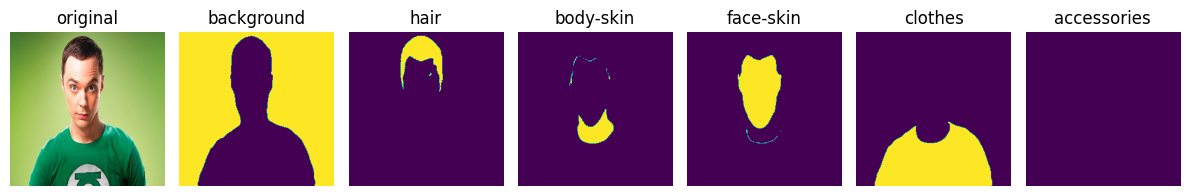

In [24]:
n = len(CLASSES)
fig, ax = plt.subplots(nrows=1, ncols=(n + 1), figsize=(12, 12))

ax[0].set_title('original')
ax[0].imshow(image[0, :, :, :])
ax[0].axis("off")

for i in range(n):
    sample = tvm_output[0, :, :, i]
    sample_label = CLASSES[i]

    ax[i + 1].set_title(sample_label)
    ax[i + 1].imshow(sample > 0.5)
    ax[i + 1].axis("off")

plt.tight_layout()
plt.show()

### Save TVMC model

Let's save our untuned model.

In [37]:
def convert_params_to_numpy(parameters: dict[str: tvm.nd.NDArray]) -> dict[str: np.ndarray]:
    patched_parameters = {}

    for k, v in parameters.items():
        patched_parameters[k] = v.numpy()
    
    return patched_parameters

In [38]:
def load_tvm_parameters(path: str) -> dict[str: tvm.nd.NDArray]:
    raw_parameters = np.load(path)
    
    patched_parameters = {}

    for k, v in raw_parameters.items():
        patched_parameters[k] = tvm.nd.array(v)
    
    return patched_parameters

In [25]:
def add_prefix_to_parameters(parameters: dict,
                             prefix: str) -> dict:
    patched_parameters = {}

    for k, v in parameters.items():
        patched_parameters[f"{prefix}{k}"] = v
    
    return patched_parameters

In [26]:
def create_tvmc_model(model, 
                      parameters,
                      file_name):
    with open(f"{file_name}.txt", "w") as f:
        f.write(repr(mod_nchw))
        
    return tvmc.load(f"{file_name}.txt", shape_dict={ input_tensor: input_shape, **vparams }, model_format="relay")

In [27]:
vparams = add_prefix_to_parameters(params, prefix='v')

In [40]:
np.save('parameters', convert_params_to_numpy(vparams))

In [41]:
tvmc_model = create_tvmc_model(mod_nchw, vparams, file_name='selfie_multiclass_256x256')

In [42]:
tvmc.compile(tvmc_model, target=target, 
             tuning_records='tvmc_compilation.log', 
             package_path="selfie_multiclass_not_tuned.tar")

#### Check inference on TVMC model

In [43]:
package = tvmc.TVMCPackage(package_path="selfie_multiclass_256x256.tar")

inputs = {input_tensor: image, **vparams }
num_iter = 10
result = tvmc.run(package, device="cpu", inputs=inputs, 
                  benchmark=True, number=num_iter)

tvmc_output = result.outputs["output_0"]
print('output shape:', tvmc_output.shape)

2023-12-17 22:24:17.778 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp6bo2pyn6/mod.so


output shape: (1, 256, 256, 6)


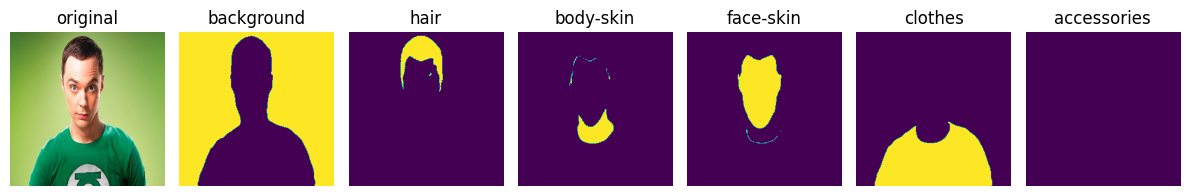

In [44]:
n = len(CLASSES)
fig, ax = plt.subplots(nrows=1, ncols=(n + 1), figsize=(12, 12))

ax[0].set_title('original')
ax[0].imshow(image[0, :, :, :])
ax[0].axis("off")

for i in range(n):
    sample = tvmc_output[0, :, :, i]
    sample_label = CLASSES[i]

    ax[i + 1].set_title(sample_label)
    ax[i + 1].imshow(sample > 0.5)
    ax[i + 1].axis("off")

plt.tight_layout()
plt.show()

### AutoTVM tuning

In [45]:
log_file = "statistics.log"

In [46]:
def evaluate_performance(input_name, lib, data_shape, dtype="float32"):
    # upload parameters to device
    dev = tvm.cpu()
    data_tvm = tvm.nd.array((np.random.uniform(size=data_shape)).astype(dtype))
    module = graph_executor.GraphModule(lib["default"](dev))
    module.set_input(input_name, data_tvm)

    # evaluate
    print("Evaluate inference time cost...")
    print(module.benchmark(dev, number=100, repeat=3))

In [47]:
# extract workloads from relay program
def extract_tasks_autotvm(mod, target, params):
    print("Extract tasks...")
    print(mod)
    tasks = autotvm.task.extract_from_program(
        mod, target=target, params=params
    )
    assert(len(tasks) > 0)
    return tasks

def evaluate_autotvm(input_name, model, data_shape, log_file, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext():
        print("Compile...")
        lib = relay.build(model, target=target, params=params)
        evaluate_performance(input_name, lib, data_shape)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with autotvm.apply_history_best(log_file):
        print("Compile...")
        with tvm.transform.PassContext():
            lib = relay.build(model, target=target, params=params)
        evaluate_performance(input_name, lib, data_shape)

In [48]:
# Set number of threads used for tuning based on the number of
# physical CPU cores on your machine.
num_threads = multiprocessing.cpu_count()
print("Num threads: ", num_threads)
os.environ["TVM_NUM_THREADS"] = str(num_threads)

Num threads:  16


In [49]:
tuning_option = {
    "log_filename": log_file,
    "tuner": "gridsearch",
    "early_stopping": True,
    "measure_option": autotvm.measure_option(
        builder=autotvm.LocalBuilder(),
        runner=autotvm.LocalRunner(
            number=1, repeat=10, min_repeat_ms=0, enable_cpu_cache_flush=True
        ),
    ),
}

In [50]:
def run_tuning_autotvm(
    tasks, measure_option, tuner="gridsearch", early_stopping=None, log_filename="tuning.log"
):
    for i, task in enumerate(tasks):
        prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))

        # create tuner
        if tuner == "xgb" or tuner == "xgb-rank":
            tuner_obj = XGBTuner(task, loss_type="rank")
        elif tuner == "ga":
            tuner_obj = GATuner(task, pop_size=50)
        elif tuner == "random":
            tuner_obj = RandomTuner(task)
        elif tuner == "gridsearch":
            tuner_obj = GridSearchTuner(task)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        # do tuning
        n_trial = len(task.config_space)
        tuner_obj.tune(
            n_trial=n_trial,
            early_stopping=early_stopping,
            measure_option=measure_option,
            callbacks=[
                autotvm.callback.progress_bar(n_trial, prefix=prefix),
                autotvm.callback.log_to_file(log_filename),
            ],
        )

In [51]:
tasks = extract_tasks_autotvm(mod_nchw, target, params)
run_tuning_autotvm(tasks, **tuning_option)

Extract tasks...
def @main(%input_29: Tensor[(1, 256, 256, 3), float32] /* ty=Tensor[(1, 256, 256, 3), float32] */, %v_param_1: Tensor[(3, 3, 3, 16), float32] /* ty=Tensor[(3, 3, 3, 16), float32] */, %v_param_2: Tensor[(16), float32] /* ty=Tensor[(16), float32] */, %v_param_7: Tensor[(1, 1, 16, 96), float32] /* ty=Tensor[(1, 1, 16, 96), float32] */, %v_param_8: Tensor[(96), float32] /* ty=Tensor[(96), float32] */, %v_param_9: Tensor[(3, 3, 96, 1), float32] /* ty=Tensor[(3, 3, 96, 1), float32] */, %v_param_10: Tensor[(96), float32] /* ty=Tensor[(96), float32] */, %v_param_11: Tensor[(1, 1, 96, 64), float32] /* ty=Tensor[(1, 1, 96, 64), float32] */, %v_param_12: Tensor[(64), float32] /* ty=Tensor[(64), float32] */, %v_param_13: Tensor[(1, 1, 64, 384), float32] /* ty=Tensor[(1, 1, 64, 384), float32] */, %v_param_14: Tensor[(384), float32] /* ty=Tensor[(384), float32] */, %v_param_15: Tensor[(3, 3, 384, 1), float32] /* ty=Tensor[(3, 3, 384, 1), float32] */, %v_param_16: Tensor[(384), float

2023-12-17 22:25:02.670 INFO Finish serving ('127.0.0.1', 53015)
2023-12-17 22:25:03.617 INFO Finish serving ('127.0.0.1', 53017)
2023-12-17 22:25:08.377 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpx4rp54bh/tmp_func_e0350817e26d601d.tar
2023-12-17 22:25:08.496 INFO Finish serving ('127.0.0.1', 53019)
2023-12-17 22:25:11.140 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpesf1io9j/tmp_func_2b250298e5eba1e0.tar
2023-12-17 22:25:11.262 INFO Finish serving ('127.0.0.1', 53027)
2023-12-17 22:25:12.578 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpmlki835g/tmp_func_246a9f1cb64a842f.tar
2023-12-17 22:25:12.700 INFO Finish serving ('127.0.0.1', 53029)
2023-12-17 22:25:14.096 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpcmphbsv9/tmp_func_3275900f50b35021.tar
2023-12-17 22:25:14.213 INFO Finish serving ('127.0.0.1', 53031)
2023-12-17 22:25:15.670 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task  1/48]  Current/Best:  124.47/ 162.07 GFLOPS | Progress: (16/140) | 33.18 s

2023-12-17 22:25:32.257 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmplh3d4k75/tmp_func_dd0577ce3b364622.tar
2023-12-17 22:25:32.379 INFO Finish serving ('127.0.0.1', 53055)


 Done.
[Task  2/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/840) | 0.00 s

2023-12-17 22:25:35.297 INFO Finish serving ('127.0.0.1', 53059)
2023-12-17 22:25:36.331 INFO Finish serving ('127.0.0.1', 53061)
2023-12-17 22:25:38.225 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp0ko9imom/tmp_func_fe7041b45746f18c.tar
2023-12-17 22:25:38.381 INFO Finish serving ('127.0.0.1', 53063)
2023-12-17 22:25:39.693 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpofnc9o1w/tmp_func_20300e5c8eedbada.tar
2023-12-17 22:25:39.847 INFO Finish serving ('127.0.0.1', 53065)
2023-12-17 22:25:41.370 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp7lh8eddl/tmp_func_b5734a9473b96a9f.tar
2023-12-17 22:25:41.517 INFO Finish serving ('127.0.0.1', 53067)
2023-12-17 22:25:42.838 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpksdtv7yr/tmp_func_a32658c675e0044d.tar
2023-12-17 22:25:42.987 INFO Finish serving ('127.0.0.1', 53069)
2023-12-17 22:25:44.415 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task  2/48]  Current/Best:  105.30/ 105.30 GFLOPS | Progress: (16/840) | 29.28 s

2023-12-17 22:26:01.713 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp7co3yab1/tmp_func_5558fb99d890dad.tar
2023-12-17 22:26:01.859 INFO Finish serving ('127.0.0.1', 53093)


 Done.
[Task  3/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/2016) | 0.00 s

2023-12-17 22:26:04.854 INFO Finish serving ('127.0.0.1', 53097)
2023-12-17 22:26:05.848 INFO Finish serving ('127.0.0.1', 53099)
2023-12-17 22:26:07.197 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpibihg28f/tmp_func_5d657c977df3551f.tar
2023-12-17 22:26:07.371 INFO Finish serving ('127.0.0.1', 53101)
2023-12-17 22:26:08.668 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp2fyc349b/tmp_func_2ba333962ba55c54.tar
2023-12-17 22:26:08.851 INFO Finish serving ('127.0.0.1', 53103)
2023-12-17 22:26:10.209 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpsplqgm_k/tmp_func_76a5d302453d1755.tar
2023-12-17 22:26:10.391 INFO Finish serving ('127.0.0.1', 53105)
2023-12-17 22:26:11.771 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpnxcrzjfg/tmp_func_2697cbba91b21a07.tar
2023-12-17 22:26:11.951 INFO Finish serving ('127.0.0.1', 53107)
2023-12-17 22:26:13.345 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task  3/48]  Current/Best:   54.88/  65.06 GFLOPS | Progress: (16/2016) | 30.40 s

2023-12-17 22:26:32.252 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpeumepuh2/tmp_func_b1efde33a3b3d481.tar
2023-12-17 22:26:32.436 INFO Finish serving ('127.0.0.1', 53131)


 Done.
[Task  4/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/1176) | 0.00 s

2023-12-17 22:26:35.339 INFO Finish serving ('127.0.0.1', 53136)
2023-12-17 22:26:36.318 INFO Finish serving ('127.0.0.1', 53138)
2023-12-17 22:26:38.611 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpexqcq007/tmp_func_6d9982a6508d4964.tar
2023-12-17 22:26:38.852 INFO Finish serving ('127.0.0.1', 53140)
2023-12-17 22:26:40.219 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpy313b6e2/tmp_func_264f090fffe1899b.tar
2023-12-17 22:26:40.452 INFO Finish serving ('127.0.0.1', 53142)
2023-12-17 22:26:41.759 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmppjfzwlr4/tmp_func_c75bdc256c71ba73.tar
2023-12-17 22:26:41.970 INFO Finish serving ('127.0.0.1', 53144)
2023-12-17 22:26:43.325 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpzlfs79gl/tmp_func_b72abeadb96b5af1.tar
2023-12-17 22:26:43.536 INFO Finish serving ('127.0.0.1', 53146)
2023-12-17 22:26:44.854 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task  4/48]  Current/Best:   92.36/  92.36 GFLOPS | Progress: (16/1176) | 29.69 s

2023-12-17 22:27:02.105 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmppc4pushz/tmp_func_af88b007ef328739.tar
2023-12-17 22:27:02.306 INFO Finish serving ('127.0.0.1', 53176)


 Done.
[Task  5/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/1568) | 0.00 s

2023-12-17 22:27:05.211 INFO Finish serving ('127.0.0.1', 53180)
2023-12-17 22:27:06.231 INFO Finish serving ('127.0.0.1', 53182)
2023-12-17 22:27:08.070 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpt7cbqdid/tmp_func_8d0187e840c02769.tar
2023-12-17 22:27:08.574 INFO Finish serving ('127.0.0.1', 53184)
2023-12-17 22:27:10.109 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpwr6l1x8p/tmp_func_8e90b8e860c5d2cf.tar
2023-12-17 22:27:10.559 INFO Finish serving ('127.0.0.1', 53186)
2023-12-17 22:27:11.965 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp_yolqme4/tmp_func_b81ee64f6c5b30fc.tar
2023-12-17 22:27:12.368 INFO Finish serving ('127.0.0.1', 53188)
2023-12-17 22:27:14.065 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp25hqb842/tmp_func_513d5a9e192e1f65.tar
2023-12-17 22:27:14.604 INFO Finish serving ('127.0.0.1', 53190)
2023-12-17 22:27:16.257 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task  5/48]  Current/Best:   88.00/  92.26 GFLOPS | Progress: (16/1568) | 33.57 s Done.
[Task  6/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/3584) | 0.00 s

2023-12-17 22:27:36.050 INFO Finish serving ('127.0.0.1', 53214)
2023-12-17 22:27:38.957 INFO Finish serving ('127.0.0.1', 53218)
2023-12-17 22:27:39.962 INFO Finish serving ('127.0.0.1', 53220)
2023-12-17 22:27:41.330 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp40w8dxzp/tmp_func_36d80e27d792cebb.tar
2023-12-17 22:27:41.677 INFO Finish serving ('127.0.0.1', 53222)
2023-12-17 22:27:43.002 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp9vtfd9qt/tmp_func_e171f560ab9307f9.tar
2023-12-17 22:27:43.369 INFO Finish serving ('127.0.0.1', 53224)
2023-12-17 22:27:44.723 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmppgt144sk/tmp_func_4a204db120c3a443.tar
2023-12-17 22:27:45.094 INFO Finish serving ('127.0.0.1', 53226)
2023-12-17 22:27:46.571 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpisx9y1yr/tmp_func_571355ad2534f4e9.tar
2023-12-17 22:27:46.928 INFO Finish serving ('127.0.0.1', 53228)
2023-12-17 22:27:

[Task  6/48]  Current/Best:    3.88/  18.74 GFLOPS | Progress: (16/3584) | 32.40 s Done.
[Task  7/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/1792) | 0.00 s

2023-12-17 22:28:08.637 INFO Finish serving ('127.0.0.1', 53252)
2023-12-17 22:28:11.602 INFO Finish serving ('127.0.0.1', 53256)
2023-12-17 22:28:12.590 INFO Finish serving ('127.0.0.1', 53258)
2023-12-17 22:28:14.572 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpof7fn_8n/tmp_func_cce424bfbc18fb3b.tar
2023-12-17 22:28:14.794 INFO Finish serving ('127.0.0.1', 53260)
2023-12-17 22:28:16.032 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpzxy6l1rc/tmp_func_70f0c9442a83a45c.tar
2023-12-17 22:28:16.310 INFO Finish serving ('127.0.0.1', 53262)
2023-12-17 22:28:17.605 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpgxj9loil/tmp_func_90379fdea74db518.tar
2023-12-17 22:28:17.861 INFO Finish serving ('127.0.0.1', 53264)
2023-12-17 22:28:19.370 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpw__xscei/tmp_func_f592044356aa7583.tar
2023-12-17 22:28:19.677 INFO Finish serving ('127.0.0.1', 53266)
2023-12-17 22:28:

[Task  7/48]  Current/Best:   55.71/  86.39 GFLOPS | Progress: (16/1792) | 31.59 s Done.
[Task  8/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/2016) | 0.00 s

2023-12-17 22:28:40.402 INFO Finish serving ('127.0.0.1', 53290)
2023-12-17 22:28:43.512 INFO Finish serving ('127.0.0.1', 53294)
2023-12-17 22:28:44.738 INFO Finish serving ('127.0.0.1', 53296)
2023-12-17 22:28:46.975 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpf5lb1w13/tmp_func_f52e403a95fdff4b.tar
2023-12-17 22:28:47.349 INFO Finish serving ('127.0.0.1', 53298)
2023-12-17 22:28:49.259 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpep_bpf3w/tmp_func_8ba4395f6fa36e23.tar
2023-12-17 22:28:49.797 INFO Finish serving ('127.0.0.1', 53300)
2023-12-17 22:28:51.346 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpjsp4vcpd/tmp_func_f64489ad3692409.tar
2023-12-17 22:28:51.731 INFO Finish serving ('127.0.0.1', 53302)
2023-12-17 22:28:53.257 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp_s2omknn/tmp_func_4ecf88c30d410262.tar
2023-12-17 22:28:53.589 INFO Finish serving ('127.0.0.1', 53304)
2023-12-17 22:28:5

[Task  8/48]  Current/Best:   76.12/  91.72 GFLOPS | Progress: (16/2016) | 36.03 s Done.
[Task  9/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/4536) | 0.00 s

2023-12-17 22:29:16.609 INFO Finish serving ('127.0.0.1', 53329)
2023-12-17 22:29:19.996 INFO Finish serving ('127.0.0.1', 53333)
2023-12-17 22:29:21.084 INFO Finish serving ('127.0.0.1', 53335)
2023-12-17 22:29:23.044 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfjj0g83g/tmp_func_9b1e27474ae7cab2.tar
2023-12-17 22:29:23.301 INFO Finish serving ('127.0.0.1', 53337)
2023-12-17 22:29:24.715 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpoeciwyyc/tmp_func_69087f0fec5b993.tar
2023-12-17 22:29:24.975 INFO Finish serving ('127.0.0.1', 53339)
2023-12-17 22:29:26.305 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfzhkjes0/tmp_func_aef87c70fe3a9dca.tar
2023-12-17 22:29:26.568 INFO Finish serving ('127.0.0.1', 53341)
2023-12-17 22:29:28.065 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpompp7kii/tmp_func_a1b1dec10d4a2f16.tar
2023-12-17 22:29:28.324 INFO Finish serving ('127.0.0.1', 53343)
2023-12-17 22:29:2

[Task  9/48]  Current/Best:   14.61/  37.34 GFLOPS | Progress: (16/4536) | 31.80 s Done.
[Task 10/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/2016) | 0.00 s

2023-12-17 22:29:48.608 INFO Finish serving ('127.0.0.1', 53367)
2023-12-17 22:29:51.746 INFO Finish serving ('127.0.0.1', 53371)
2023-12-17 22:29:52.876 INFO Finish serving ('127.0.0.1', 53373)
2023-12-17 22:29:55.134 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpv_qvtfu8/tmp_func_1d424e5446066d10.tar
2023-12-17 22:29:55.458 INFO Finish serving ('127.0.0.1', 53375)
2023-12-17 22:29:56.768 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpet7q6qjg/tmp_func_9d4b4fa6c384c486.tar
2023-12-17 22:29:57.203 INFO Finish serving ('127.0.0.1', 53377)
2023-12-17 22:29:58.565 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp3mq00wua/tmp_func_cfbd6398b5061f41.tar
2023-12-17 22:29:58.974 INFO Finish serving ('127.0.0.1', 53379)
2023-12-17 22:30:00.366 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfu1i_67b/tmp_func_b7571cd3666cfe0b.tar
2023-12-17 22:30:00.757 INFO Finish serving ('127.0.0.1', 53381)
2023-12-17 22:30:

[Task 10/48]  Current/Best:   40.23/  78.15 GFLOPS | Progress: (16/2016) | 34.11 s Done.
[Task 11/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/3888) | 0.00 s

2023-12-17 22:30:22.907 INFO Finish serving ('127.0.0.1', 53405)
2023-12-17 22:30:26.143 INFO Finish serving ('127.0.0.1', 53409)
2023-12-17 22:30:27.236 INFO Finish serving ('127.0.0.1', 53411)
2023-12-17 22:30:28.684 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpflfydy1z/tmp_func_fcf878366eaeab31.tar
2023-12-17 22:30:28.911 INFO Finish serving ('127.0.0.1', 53413)
2023-12-17 22:30:30.383 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp19nqvi3e/tmp_func_fbfd2e1774712ffa.tar
2023-12-17 22:30:30.609 INFO Finish serving ('127.0.0.1', 53415)
2023-12-17 22:30:32.549 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpgjz_thre/tmp_func_43fa87501f249751.tar
2023-12-17 22:30:32.772 INFO Finish serving ('127.0.0.1', 53417)
2023-12-17 22:30:34.212 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp1cn9nmmh/tmp_func_71a604c0909b2fcd.tar
2023-12-17 22:30:34.439 INFO Finish serving ('127.0.0.1', 53419)
2023-12-17 22:30:

[Task 11/48]  Current/Best:   12.15/  24.44 GFLOPS | Progress: (16/3888) | 33.17 s Done.
[Task 12/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/1944) | 0.00 s

2023-12-17 22:30:56.259 INFO Finish serving ('127.0.0.1', 53443)
2023-12-17 22:30:59.569 INFO Finish serving ('127.0.0.1', 53447)
2023-12-17 22:31:00.669 INFO Finish serving ('127.0.0.1', 53449)
2023-12-17 22:31:02.241 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpjedgwqix/tmp_func_e58b94d5530d394.tar
2023-12-17 22:31:02.456 INFO Finish serving ('127.0.0.1', 53451)
2023-12-17 22:31:04.328 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpcnsk9jqy/tmp_func_5fbcc9af5f32a228.tar
2023-12-17 22:31:04.625 INFO Finish serving ('127.0.0.1', 53453)
2023-12-17 22:31:06.097 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp8c_a53kb/tmp_func_85923d614dae3243.tar
2023-12-17 22:31:06.338 INFO Finish serving ('127.0.0.1', 53455)
2023-12-17 22:31:07.769 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpz14kx_o8/tmp_func_35f16e3183948284.tar
2023-12-17 22:31:08.043 INFO Finish serving ('127.0.0.1', 53457)
2023-12-17 22:31:0

[Task 12/48]  Current/Best:   59.28/  65.92 GFLOPS | Progress: (16/1944) | 32.88 s Done.
[Task 13/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/864) | 0.00 s

2023-12-17 22:31:29.317 INFO Finish serving ('127.0.0.1', 53488)
2023-12-17 22:31:32.754 INFO Finish serving ('127.0.0.1', 53492)
2023-12-17 22:31:33.913 INFO Finish serving ('127.0.0.1', 53494)
2023-12-17 22:31:35.991 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpkfohjx5a/tmp_func_22b4396c45f38944.tar
2023-12-17 22:31:36.170 INFO Finish serving ('127.0.0.1', 53496)
2023-12-17 22:31:37.786 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpo4l4auew/tmp_func_ab373186e31bc324.tar
2023-12-17 22:31:38.039 INFO Finish serving ('127.0.0.1', 53498)
2023-12-17 22:31:39.473 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpybae8hm2/tmp_func_b54ebe29932efcb9.tar
2023-12-17 22:31:39.707 INFO Finish serving ('127.0.0.1', 53500)
2023-12-17 22:31:41.182 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfj5dkequ/tmp_func_f10c18a763ed5f4a.tar
2023-12-17 22:31:41.439 INFO Finish serving ('127.0.0.1', 53502)
2023-12-17 22:31:

[Task 13/48]  Current/Best:   88.32/ 142.87 GFLOPS | Progress: (16/864) | 32.77 s Done.
[Task 14/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/768) | 0.00 s

2023-12-17 22:32:02.262 INFO Finish serving ('127.0.0.1', 53541)
2023-12-17 22:32:05.362 INFO Finish serving ('127.0.0.1', 53545)
2023-12-17 22:32:06.428 INFO Finish serving ('127.0.0.1', 53547)
2023-12-17 22:32:07.872 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpba7hj_q7/tmp_func_a3b71f8ef821c9e5.tar
2023-12-17 22:32:07.990 INFO Finish serving ('127.0.0.1', 53549)
2023-12-17 22:32:09.354 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmppezp704y/tmp_func_e74910863aed939f.tar
2023-12-17 22:32:09.489 INFO Finish serving ('127.0.0.1', 53551)
2023-12-17 22:32:10.919 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp3b65xfkm/tmp_func_3631bd51dc35affc.tar
2023-12-17 22:32:11.042 INFO Finish serving ('127.0.0.1', 53554)
2023-12-17 22:32:12.488 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp2rlk5uvm/tmp_func_793ef37c465a3607.tar
2023-12-17 22:32:12.610 INFO Finish serving ('127.0.0.1', 53556)
2023-12-17 22:32:

[Task 14/48]  Current/Best:   77.65/  95.25 GFLOPS | Progress: (16/768) | 29.55 s

2023-12-17 22:32:31.884 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpq13qwwn_/tmp_func_cd288622feed5816.tar
2023-12-17 22:32:32.004 INFO Finish serving ('127.0.0.1', 53580)


 Done.
[Task 15/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/1008) | 0.00 s

2023-12-17 22:32:35.144 INFO Finish serving ('127.0.0.1', 53584)
2023-12-17 22:32:36.231 INFO Finish serving ('127.0.0.1', 53586)
2023-12-17 22:32:38.287 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpjejceers/tmp_func_38f93d9acaacd009.tar
2023-12-17 22:32:38.417 INFO Finish serving ('127.0.0.1', 53588)
2023-12-17 22:32:39.934 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp5ae8tmum/tmp_func_f4a61f0807f66aff.tar
2023-12-17 22:32:40.083 INFO Finish serving ('127.0.0.1', 53590)
2023-12-17 22:32:41.499 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp4aip04q8/tmp_func_c4d3e57959539bb0.tar
2023-12-17 22:32:41.633 INFO Finish serving ('127.0.0.1', 53592)
2023-12-17 22:32:43.013 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp0bjo729m/tmp_func_b903fa2ec555a53b.tar
2023-12-17 22:32:43.148 INFO Finish serving ('127.0.0.1', 53594)
2023-12-17 22:32:44.563 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 15/48]  Current/Best:   84.42/  98.49 GFLOPS | Progress: (16/1008) | 30.84 s

2023-12-17 22:33:02.919 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpjp2m1r19/tmp_func_428bbc418a2053b5.tar
2023-12-17 22:33:03.044 INFO Finish serving ('127.0.0.1', 53618)


 Done.
[Task 16/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/1008) | 0.00 s

2023-12-17 22:33:06.479 INFO Finish serving ('127.0.0.1', 53622)
2023-12-17 22:33:07.630 INFO Finish serving ('127.0.0.1', 53624)
2023-12-17 22:33:09.766 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpcap4c20a/tmp_func_d0676273efaab761.tar
2023-12-17 22:33:09.893 INFO Finish serving ('127.0.0.1', 53626)
2023-12-17 22:33:11.334 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpi1l6co3b/tmp_func_b5d448a24e447c99.tar
2023-12-17 22:33:11.485 INFO Finish serving ('127.0.0.1', 53628)
2023-12-17 22:33:13.732 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpecegspeq/tmp_func_9baa23ecb9ca8534.tar
2023-12-17 22:33:13.869 INFO Finish serving ('127.0.0.1', 53630)
2023-12-17 22:33:15.437 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp9olabahr/tmp_func_adca6dfcc4e58911.tar
2023-12-17 22:33:15.576 INFO Finish serving ('127.0.0.1', 53632)
2023-12-17 22:33:17.120 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 16/48]  Current/Best:   72.67/  86.93 GFLOPS | Progress: (16/1008) | 33.17 s

2023-12-17 22:33:36.279 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpixcegv1r/tmp_func_e2a410b7c2c62f78.tar
2023-12-17 22:33:36.412 INFO Finish serving ('127.0.0.1', 53660)


 Done.
[Task 17/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/896) | 0.00 s

2023-12-17 22:33:39.666 INFO Finish serving ('127.0.0.1', 53664)
2023-12-17 22:33:40.747 INFO Finish serving ('127.0.0.1', 53666)
2023-12-17 22:33:42.672 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp2ozkw9ca/tmp_func_d195e75503aaf561.tar
2023-12-17 22:33:42.793 INFO Finish serving ('127.0.0.1', 53668)
2023-12-17 22:33:44.143 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpy6hdi1kp/tmp_func_f4c19c4bf9b7aadb.tar
2023-12-17 22:33:44.271 INFO Finish serving ('127.0.0.1', 53670)
2023-12-17 22:33:45.913 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp2uh3aeo_/tmp_func_700a7ecadf64f5ac.tar
2023-12-17 22:33:46.037 INFO Finish serving ('127.0.0.1', 53672)
2023-12-17 22:33:47.389 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpzghlouz1/tmp_func_4a06fb9cd05400ce.tar
2023-12-17 22:33:47.513 INFO Finish serving ('127.0.0.1', 53675)
2023-12-17 22:33:48.969 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 17/48]  Current/Best:   80.86/  81.98 GFLOPS | Progress: (16/896) | 30.31 s

2023-12-17 22:34:06.796 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmphai_8fr0/tmp_func_d9ba8e6290a76e44.tar
2023-12-17 22:34:06.918 INFO Finish serving ('127.0.0.1', 53699)


 Done.
[Task 18/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/112) | 0.00 s

2023-12-17 22:34:10.192 INFO Finish serving ('127.0.0.1', 53703)
2023-12-17 22:34:11.269 INFO Finish serving ('127.0.0.1', 53705)
2023-12-17 22:34:13.178 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp3gtb88sr/tmp_func_a73ec27a7dc729f0.tar
2023-12-17 22:34:13.292 INFO Finish serving ('127.0.0.1', 53707)
2023-12-17 22:34:14.651 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmphtc1gk6g/tmp_func_9fccdbe18d62da23.tar
2023-12-17 22:34:14.763 INFO Finish serving ('127.0.0.1', 53709)
2023-12-17 22:34:16.229 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpvr4phu7d/tmp_func_834bac97aa2a9157.tar
2023-12-17 22:34:16.343 INFO Finish serving ('127.0.0.1', 53711)
2023-12-17 22:34:17.798 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpoa2aqar1/tmp_func_cfd31ec3f1df61e6.tar
2023-12-17 22:34:17.907 INFO Finish serving ('127.0.0.1', 53713)
2023-12-17 22:34:19.368 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 18/48]  Current/Best:    6.92/  13.13 GFLOPS | Progress: (16/112) | 30.92 s

2023-12-17 22:34:37.927 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpsahzc6s0/tmp_func_e4d1985377e965cc.tar
2023-12-17 22:34:38.037 INFO Finish serving ('127.0.0.1', 53737)


 Done.
[Task 19/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/864) | 0.00 s

2023-12-17 22:34:41.636 INFO Finish serving ('127.0.0.1', 53741)
2023-12-17 22:34:42.871 INFO Finish serving ('127.0.0.1', 53743)
2023-12-17 22:34:44.604 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpg119bbme/tmp_func_8de6e8f46ea59eb0.tar
2023-12-17 22:34:44.731 INFO Finish serving ('127.0.0.1', 53745)
2023-12-17 22:34:46.305 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpk7p_d7i9/tmp_func_f75dc7e2c8259fc2.tar
2023-12-17 22:34:46.454 INFO Finish serving ('127.0.0.1', 53747)
2023-12-17 22:34:48.106 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpek3aqtb_/tmp_func_1fd036fc90d29c89.tar
2023-12-17 22:34:48.237 INFO Finish serving ('127.0.0.1', 53749)
2023-12-17 22:34:49.862 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpc6obitre/tmp_func_37eb35c835f742ce.tar
2023-12-17 22:34:49.998 INFO Finish serving ('127.0.0.1', 53751)
2023-12-17 22:34:51.777 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 19/48]  Current/Best:   86.15/  86.15 GFLOPS | Progress: (16/864) | 33.83 s

2023-12-17 22:35:11.933 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmporyhkn77/tmp_func_2932d53f4ede866c.tar
2023-12-17 22:35:12.062 INFO Finish serving ('127.0.0.1', 53779)


 Done.
[Task 20/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/2160) | 0.00 s

2023-12-17 22:35:15.729 INFO Finish serving ('127.0.0.1', 53783)
2023-12-17 22:35:16.980 INFO Finish serving ('127.0.0.1', 53785)
2023-12-17 22:35:18.657 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpphio8rdm/tmp_func_d28c523367b46d16.tar
2023-12-17 22:35:18.935 INFO Finish serving ('127.0.0.1', 53787)
2023-12-17 22:35:20.615 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpe9ajbyfe/tmp_func_fb88a1d25f7c2103.tar
2023-12-17 22:35:21.002 INFO Finish serving ('127.0.0.1', 53789)
2023-12-17 22:35:22.488 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp1aph7509/tmp_func_a074d6fb40daf285.tar
2023-12-17 22:35:22.817 INFO Finish serving ('127.0.0.1', 53791)
2023-12-17 22:35:24.281 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpsguno2zx/tmp_func_32d08770eee1d4bc.tar
2023-12-17 22:35:24.587 INFO Finish serving ('127.0.0.1', 53793)
2023-12-17 22:35:26.025 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 20/48]  Current/Best:   85.07/  91.33 GFLOPS | Progress: (16/2160) | 34.28 s Done.
[Task 21/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/4000) | 0.00 s

2023-12-17 22:35:46.548 INFO Finish serving ('127.0.0.1', 53817)
2023-12-17 22:35:50.015 INFO Finish serving ('127.0.0.1', 53821)
2023-12-17 22:35:51.216 INFO Finish serving ('127.0.0.1', 53823)
2023-12-17 22:35:53.201 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmphz3r0qeg/tmp_func_7c2953bba5049e32.tar
2023-12-17 22:35:53.368 INFO Finish serving ('127.0.0.1', 53825)
2023-12-17 22:35:54.774 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpo268gy5h/tmp_func_4d29bb3652d4b8c4.tar
2023-12-17 22:35:54.939 INFO Finish serving ('127.0.0.1', 53827)
2023-12-17 22:35:56.541 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp6qisyvis/tmp_func_99973b3290ba3900.tar
2023-12-17 22:35:56.715 INFO Finish serving ('127.0.0.1', 53829)
2023-12-17 22:35:58.346 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpjavou39i/tmp_func_965eabbfd37c80de.tar
2023-12-17 22:35:58.512 INFO Finish serving ('127.0.0.1', 53831)
2023-12-17 22:36:

[Task 21/48]  Current/Best:   16.30/  40.52 GFLOPS | Progress: (16/4000) | 34.41 s

2023-12-17 22:36:20.985 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpbrlyzrjc/tmp_func_9990f675ee832efc.tar
2023-12-17 22:36:21.157 INFO Finish serving ('127.0.0.1', 53855)


 Done.
[Task 22/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/3200) | 0.00 s

2023-12-17 22:36:24.588 INFO Finish serving ('127.0.0.1', 53859)
2023-12-17 22:36:25.737 INFO Finish serving ('127.0.0.1', 53861)
2023-12-17 22:36:27.281 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp6exq99uo/tmp_func_cfdb4cc21bdab51.tar
2023-12-17 22:36:28.041 INFO Finish serving ('127.0.0.1', 53863)
2023-12-17 22:36:29.665 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpuozvos9z/tmp_func_4219b3900f1e4e32.tar
2023-12-17 22:36:30.239 INFO Finish serving ('127.0.0.1', 53865)
2023-12-17 22:36:31.765 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfc5ntz3_/tmp_func_85d7da7463f3c4b8.tar
2023-12-17 22:36:32.219 INFO Finish serving ('127.0.0.1', 53867)
2023-12-17 22:36:33.653 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpa34nx9ph/tmp_func_d18f75edd7be507e.tar
2023-12-17 22:36:34.072 INFO Finish serving ('127.0.0.1', 53869)
2023-12-17 22:36:35.661 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 22/48]  Current/Best:   18.67/  26.07 GFLOPS | Progress: (16/3200) | 35.07 s Done.
[Task 23/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/2240) | 0.00 s

2023-12-17 22:36:56.430 INFO Finish serving ('127.0.0.1', 53894)
2023-12-17 22:36:59.859 INFO Finish serving ('127.0.0.1', 53900)
2023-12-17 22:37:01.039 INFO Finish serving ('127.0.0.1', 53902)
2023-12-17 22:37:02.939 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpkhxtc4b6/tmp_func_8f2523ab01d8d936.tar
2023-12-17 22:37:03.264 INFO Finish serving ('127.0.0.1', 53904)
2023-12-17 22:37:04.926 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpc7yuodm5/tmp_func_5f21ae71c69f6d77.tar
2023-12-17 22:37:05.238 INFO Finish serving ('127.0.0.1', 53906)
2023-12-17 22:37:06.666 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpf6qrj03p/tmp_func_3dbcb1d1f23b7c2.tar
2023-12-17 22:37:06.957 INFO Finish serving ('127.0.0.1', 53908)
2023-12-17 22:37:08.595 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpgdjmqclg/tmp_func_44b83336f01f89c8.tar
2023-12-17 22:37:08.898 INFO Finish serving ('127.0.0.1', 53910)
2023-12-17 22:37:1

[Task 23/48]  Current/Best:   23.27/  25.01 GFLOPS | Progress: (16/2240) | 37.01 s

2023-12-17 22:37:33.641 INFO Finish serving ('127.0.0.1', 53934)


 Done.
[Task 24/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/1960) | 0.00 s

2023-12-17 22:37:37.568 INFO Finish serving ('127.0.0.1', 53938)
2023-12-17 22:37:38.927 INFO Finish serving ('127.0.0.1', 53950)
2023-12-17 22:37:40.737 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmptgyj9e42/tmp_func_30da40dcf29d7b04.tar
2023-12-17 22:37:40.875 INFO Finish serving ('127.0.0.1', 53952)
2023-12-17 22:37:42.853 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp1futyhti/tmp_func_ed518a7a59b17808.tar
2023-12-17 22:37:42.984 INFO Finish serving ('127.0.0.1', 53954)
2023-12-17 22:37:44.938 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpz450h0pi/tmp_func_d594446b0a24d890.tar
2023-12-17 22:37:45.070 INFO Finish serving ('127.0.0.1', 53956)
2023-12-17 22:37:46.966 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpt8ysctc3/tmp_func_a8ac44dca754a3b4.tar
2023-12-17 22:37:47.090 INFO Finish serving ('127.0.0.1', 53958)
2023-12-17 22:37:49.199 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 24/48]  Current/Best:   34.97/  34.97 GFLOPS | Progress: (16/1960) | 37.26 s

2023-12-17 22:38:10.986 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp10j88id4/tmp_func_5a94547017c88ba0.tar
2023-12-17 22:38:11.104 INFO Finish serving ('127.0.0.1', 53982)


 Done.
[Task 25/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/2240) | 0.00 s

2023-12-17 22:38:14.392 INFO Finish serving ('127.0.0.1', 53986)
2023-12-17 22:38:15.603 INFO Finish serving ('127.0.0.1', 53988)
2023-12-17 22:38:17.059 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpwo2p5n3z/tmp_func_2cd9a1d88d440c67.tar
2023-12-17 22:38:17.198 INFO Finish serving ('127.0.0.1', 53990)
2023-12-17 22:38:18.577 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpnytift5c/tmp_func_5cdfbdd841b66f87.tar
2023-12-17 22:38:18.713 INFO Finish serving ('127.0.0.1', 53992)
2023-12-17 22:38:20.125 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpngc8ueoi/tmp_func_55ed1b8b28237bd7.tar
2023-12-17 22:38:20.259 INFO Finish serving ('127.0.0.1', 53994)
2023-12-17 22:38:21.863 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpui0ns1j4/tmp_func_c36e930900d62e90.tar
2023-12-17 22:38:22.002 INFO Finish serving ('127.0.0.1', 53996)
2023-12-17 22:38:23.864 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 25/48]  Current/Best:   28.26/  33.26 GFLOPS | Progress: (16/2240) | 30.52 s

2023-12-17 22:38:41.693 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpccvbwtic/tmp_func_dd7e7d1591b43a7c.tar
2023-12-17 22:38:41.825 INFO Finish serving ('127.0.0.1', 54021)


 Done.
[Task 26/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/2240) | 0.00 s

2023-12-17 22:38:45.267 INFO Finish serving ('127.0.0.1', 54025)
2023-12-17 22:38:46.422 INFO Finish serving ('127.0.0.1', 54027)
2023-12-17 22:38:47.927 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpr6tt450j/tmp_func_91bb472e990c1449.tar
2023-12-17 22:38:48.108 INFO Finish serving ('127.0.0.1', 54029)
2023-12-17 22:38:49.888 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp1i4m2ilm/tmp_func_3ecd7dc68e428beb.tar
2023-12-17 22:38:50.046 INFO Finish serving ('127.0.0.1', 54031)
2023-12-17 22:38:51.484 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpts7lpsqg/tmp_func_4920b43d2405b1d4.tar
2023-12-17 22:38:51.616 INFO Finish serving ('127.0.0.1', 54033)
2023-12-17 22:38:53.128 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp37rmibw2/tmp_func_24ac5105802ff95.tar
2023-12-17 22:38:53.282 INFO Finish serving ('127.0.0.1', 54035)
2023-12-17 22:38:54.804 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 26/48]  Current/Best:   24.13/  24.13 GFLOPS | Progress: (16/2240) | 30.03 s

2023-12-17 22:39:11.901 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp5o0z08_x/tmp_func_6b786a74f506f85.tar
2023-12-17 22:39:12.034 INFO Finish serving ('127.0.0.1', 54061)


 Done.
[Task 27/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/140) | 0.00 s

2023-12-17 22:39:15.159 INFO Finish serving ('127.0.0.1', 54065)
2023-12-17 22:39:16.224 INFO Finish serving ('127.0.0.1', 54067)
2023-12-17 22:39:19.668 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp8la_hfvr/tmp_func_128c27dd67df4bdf.tar
2023-12-17 22:39:19.780 INFO Finish serving ('127.0.0.1', 54069)
2023-12-17 22:39:21.347 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpj4dyq79l/tmp_func_2ad1945ae1d0b921.tar
2023-12-17 22:39:21.459 INFO Finish serving ('127.0.0.1', 54071)
2023-12-17 22:39:23.119 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpddcklsja/tmp_func_d807e0f706cde648.tar
2023-12-17 22:39:23.230 INFO Finish serving ('127.0.0.1', 54073)
2023-12-17 22:39:24.688 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpf5yuggnx/tmp_func_c4f709f02b30c42e.tar
2023-12-17 22:39:24.797 INFO Finish serving ('127.0.0.1', 54075)
2023-12-17 22:39:26.215 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 27/48]  Current/Best:    6.98/  10.23 GFLOPS | Progress: (16/140) | 32.49 s

2023-12-17 22:39:44.597 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp88wh3nv_/tmp_func_b3239ed12fe768ff.tar
2023-12-17 22:39:44.709 INFO Finish serving ('127.0.0.1', 54099)


 Done.
[Task 28/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/2560) | 0.00 s

2023-12-17 22:39:48.072 INFO Finish serving ('127.0.0.1', 54103)
2023-12-17 22:39:49.198 INFO Finish serving ('127.0.0.1', 54105)
2023-12-17 22:39:50.700 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp3nyragr0/tmp_func_744ffd602d1c3882.tar
2023-12-17 22:39:50.813 INFO Finish serving ('127.0.0.1', 54107)
2023-12-17 22:39:52.469 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpz5c0ea_2/tmp_func_334d5bceaaae7dfc.tar
2023-12-17 22:39:52.581 INFO Finish serving ('127.0.0.1', 54109)
2023-12-17 22:39:54.013 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpxxy9u55g/tmp_func_761611ea9e3054a5.tar
2023-12-17 22:39:54.125 INFO Finish serving ('127.0.0.1', 54111)
2023-12-17 22:39:55.534 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpm3h46xh4/tmp_func_22d0f65d71d412eb.tar
2023-12-17 22:39:55.649 INFO Finish serving ('127.0.0.1', 54113)
2023-12-17 22:39:57.098 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 28/48]  Current/Best:    5.40/  13.11 GFLOPS | Progress: (16/2560) | 30.15 s

2023-12-17 22:40:14.938 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpsd6h_92q/tmp_func_1f2a80ecce04eb02.tar
2023-12-17 22:40:15.053 INFO Finish serving ('127.0.0.1', 54137)


 Done.
[Task 29/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/1120) | 0.00 s

2023-12-17 22:40:18.619 INFO Finish serving ('127.0.0.1', 54141)
2023-12-17 22:40:19.848 INFO Finish serving ('127.0.0.1', 54143)
2023-12-17 22:40:21.633 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmphaosx850/tmp_func_336e6e56e43c2df4.tar
2023-12-17 22:40:21.765 INFO Finish serving ('127.0.0.1', 54145)
2023-12-17 22:40:23.398 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpjqwcv78h/tmp_func_6919c6ed0c0b09e4.tar
2023-12-17 22:40:23.527 INFO Finish serving ('127.0.0.1', 54147)
2023-12-17 22:40:25.301 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp9a7no3zg/tmp_func_1694ab99c78d1c01.tar
2023-12-17 22:40:25.427 INFO Finish serving ('127.0.0.1', 54149)
2023-12-17 22:40:27.067 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp3qnh1c7m/tmp_func_eeca29ace95e293e.tar
2023-12-17 22:40:27.189 INFO Finish serving ('127.0.0.1', 54151)
2023-12-17 22:40:28.874 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 29/48]  Current/Best:   19.31/  23.23 GFLOPS | Progress: (16/1120) | 32.81 s

2023-12-17 22:40:47.955 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpyldutuut/tmp_func_e403a54421533e47.tar
2023-12-17 22:40:48.073 INFO Finish serving ('127.0.0.1', 54175)


 Done.
[Task 30/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/972) | 0.00 s

2023-12-17 22:40:51.336 INFO Finish serving ('127.0.0.1', 54179)
2023-12-17 22:40:52.406 INFO Finish serving ('127.0.0.1', 54181)
2023-12-17 22:40:53.768 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpvl0j94d3/tmp_func_a50102ba125fc7de.tar
2023-12-17 22:40:53.888 INFO Finish serving ('127.0.0.1', 54183)
2023-12-17 22:40:55.265 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp4hhblr9g/tmp_func_9b1909217a2e26db.tar
2023-12-17 22:40:55.386 INFO Finish serving ('127.0.0.1', 54185)
2023-12-17 22:40:56.781 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpihwjsmf4/tmp_func_de72b31c5c32b5e1.tar
2023-12-17 22:40:56.900 INFO Finish serving ('127.0.0.1', 54187)
2023-12-17 22:40:58.329 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp8pdhsy93/tmp_func_10c5854aa19143f0.tar
2023-12-17 22:40:58.450 INFO Finish serving ('127.0.0.1', 54189)
2023-12-17 22:40:59.903 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 30/48]  Current/Best:    6.30/  15.02 GFLOPS | Progress: (16/972) | 32.12 s

2023-12-17 22:41:20.253 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpdq02rgnz/tmp_func_c9ca08ff69bd4c60.tar
2023-12-17 22:41:20.378 INFO Finish serving ('127.0.0.1', 54213)


 Done.
[Task 31/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/756) | 0.00 s

2023-12-17 22:41:24.207 INFO Finish serving ('127.0.0.1', 54217)
2023-12-17 22:41:25.472 INFO Finish serving ('127.0.0.1', 54219)
2023-12-17 22:41:27.203 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpyt30w2u_/tmp_func_33d3ce6b0fffc1f2.tar
2023-12-17 22:41:27.330 INFO Finish serving ('127.0.0.1', 54221)
2023-12-17 22:41:28.930 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpzrhp4cif/tmp_func_3822ff76980897bd.tar
2023-12-17 22:41:29.060 INFO Finish serving ('127.0.0.1', 54223)
2023-12-17 22:41:30.609 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp2yquwob9/tmp_func_a0fc707652c2cb27.tar
2023-12-17 22:41:30.740 INFO Finish serving ('127.0.0.1', 54225)
2023-12-17 22:41:32.605 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmppr6iz4ts/tmp_func_8ee99b6a64403c3b.tar
2023-12-17 22:41:32.734 INFO Finish serving ('127.0.0.1', 54227)
2023-12-17 22:41:34.161 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 31/48]  Current/Best:   48.59/  78.26 GFLOPS | Progress: (16/756) | 32.54 s

2023-12-17 22:41:52.985 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpmicg_fpd/tmp_func_a0133494c4a20e26.tar
2023-12-17 22:41:53.111 INFO Finish serving ('127.0.0.1', 54255)


 Done.
[Task 32/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/896) | 0.00 s

2023-12-17 22:41:56.533 INFO Finish serving ('127.0.0.1', 54260)
2023-12-17 22:41:57.733 INFO Finish serving ('127.0.0.1', 54263)
2023-12-17 22:41:59.195 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpqgvzn8sr/tmp_func_8336142e5bff1a81.tar
2023-12-17 22:41:59.327 INFO Finish serving ('127.0.0.1', 54265)
2023-12-17 22:42:00.889 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp9fwqj7nv/tmp_func_eeb4d73b2f5866cd.tar
2023-12-17 22:42:01.021 INFO Finish serving ('127.0.0.1', 54269)
2023-12-17 22:42:02.487 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpmdq2by9y/tmp_func_137c1328218eac04.tar
2023-12-17 22:42:02.618 INFO Finish serving ('127.0.0.1', 54271)
2023-12-17 22:42:04.293 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp5szr41be/tmp_func_23334e260b4975f.tar
2023-12-17 22:42:04.427 INFO Finish serving ('127.0.0.1', 54273)
2023-12-17 22:42:05.979 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 32/48]  Current/Best:    4.10/  13.91 GFLOPS | Progress: (16/896) | 33.68 s

2023-12-17 22:42:26.841 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpym4rs_0n/tmp_func_b60272d6ccd0c3d3.tar
2023-12-17 22:42:26.979 INFO Finish serving ('127.0.0.1', 54297)


 Done.
[Task 33/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/784) | 0.00 s

2023-12-17 22:42:30.647 INFO Finish serving ('127.0.0.1', 54302)
2023-12-17 22:42:31.855 INFO Finish serving ('127.0.0.1', 54304)
2023-12-17 22:42:34.378 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp_3j_sh_t/tmp_func_7881dfa407a04ff1.tar
2023-12-17 22:42:34.521 INFO Finish serving ('127.0.0.1', 54306)
2023-12-17 22:42:36.373 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpzxigcfdo/tmp_func_77234c01a826def8.tar
2023-12-17 22:42:36.530 INFO Finish serving ('127.0.0.1', 54308)
2023-12-17 22:42:37.986 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmphp3055e1/tmp_func_faa8c8e77e0218b5.tar
2023-12-17 22:42:38.136 INFO Finish serving ('127.0.0.1', 54310)
2023-12-17 22:42:39.695 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp0weipeyb/tmp_func_2393923a70eb411c.tar
2023-12-17 22:42:39.844 INFO Finish serving ('127.0.0.1', 54313)
2023-12-17 22:42:41.518 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 33/48]  Current/Best:   78.07/  82.48 GFLOPS | Progress: (16/784) | 34.10 s

2023-12-17 22:43:01.129 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp8ga7j4_9/tmp_func_4c341ceb3b34c288.tar
2023-12-17 22:43:01.267 INFO Finish serving ('127.0.0.1', 54339)


 Done.
[Task 34/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/350) | 0.00 s

2023-12-17 22:43:04.924 INFO Finish serving ('127.0.0.1', 54343)
2023-12-17 22:43:06.294 INFO Finish serving ('127.0.0.1', 54345)
2023-12-17 22:43:07.913 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpx63u2a2z/tmp_func_a1c1ff5ace8dab0c.tar
2023-12-17 22:43:08.034 INFO Finish serving ('127.0.0.1', 54347)
2023-12-17 22:43:09.928 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp40sont0g/tmp_func_2d8240f38a060adf.tar
2023-12-17 22:43:10.051 INFO Finish serving ('127.0.0.1', 54349)
2023-12-17 22:43:11.930 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmps0y5jnsl/tmp_func_b553c58af59bfd7c.tar
2023-12-17 22:43:12.054 INFO Finish serving ('127.0.0.1', 54351)
2023-12-17 22:43:14.036 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpsh16ulyf/tmp_func_e153bf54e50a4a69.tar
2023-12-17 22:43:14.242 INFO Finish serving ('127.0.0.1', 54353)
2023-12-17 22:43:16.337 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 34/48]  Current/Best:   11.03/  14.95 GFLOPS | Progress: (16/350) | 39.95 s

2023-12-17 22:43:41.288 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmptpfk0qp2/tmp_func_f00e0957b632eee7.tar
2023-12-17 22:43:41.412 INFO Finish serving ('127.0.0.1', 54387)


 Done.
[Task 35/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/490) | 0.00 s

2023-12-17 22:43:45.064 INFO Finish serving ('127.0.0.1', 54397)
2023-12-17 22:43:46.250 INFO Finish serving ('127.0.0.1', 54399)
2023-12-17 22:43:48.497 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpszrgu3f6/tmp_func_6161873627fa6dbb.tar
2023-12-17 22:43:48.641 INFO Finish serving ('127.0.0.1', 54401)
2023-12-17 22:43:50.300 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp8okrtdew/tmp_func_53488ce9c2ab9b21.tar
2023-12-17 22:43:50.445 INFO Finish serving ('127.0.0.1', 54403)
2023-12-17 22:43:52.302 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmptiepofsy/tmp_func_37dbd7cb0a20eb3f.tar
2023-12-17 22:43:52.457 INFO Finish serving ('127.0.0.1', 54405)
2023-12-17 22:43:54.115 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmprlkyu91j/tmp_func_1383381ced5102f8.tar
2023-12-17 22:43:54.257 INFO Finish serving ('127.0.0.1', 54407)
2023-12-17 22:43:56.494 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 35/48]  Current/Best:  177.05/ 177.05 GFLOPS | Progress: (16/490) | 39.13 s

2023-12-17 22:44:20.610 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp_n7lsbqu/tmp_func_682a4ebdce14d741.tar
2023-12-17 22:44:20.747 INFO Finish serving ('127.0.0.1', 54432)


 Done.
[Task 36/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/686) | 0.00 s

2023-12-17 22:44:24.834 INFO Finish serving ('127.0.0.1', 54436)
2023-12-17 22:44:26.363 INFO Finish serving ('127.0.0.1', 54438)
2023-12-17 22:44:28.135 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpv6fyq0ci/tmp_func_82802320525b4517.tar
2023-12-17 22:44:28.300 INFO Finish serving ('127.0.0.1', 54440)
2023-12-17 22:44:30.227 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpccsofwjl/tmp_func_b644e6508745341f.tar
2023-12-17 22:44:30.395 INFO Finish serving ('127.0.0.1', 54442)
2023-12-17 22:44:32.671 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpnnrdx4bm/tmp_func_92d98bed8f71f4b.tar
2023-12-17 22:44:32.833 INFO Finish serving ('127.0.0.1', 54444)
2023-12-17 22:44:34.514 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpe3jh9p5k/tmp_func_40f2f950bb3f84e0.tar
2023-12-17 22:44:34.678 INFO Finish serving ('127.0.0.1', 54446)
2023-12-17 22:44:36.441 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 36/48]  Current/Best:   20.61/  70.63 GFLOPS | Progress: (16/686) | 35.16 s

2023-12-17 22:44:55.952 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpc6jw79mu/tmp_func_fd310d7a405fe4e1.tar
2023-12-17 22:44:56.118 INFO Finish serving ('127.0.0.1', 54470)


 Done.
[Task 37/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/686) | 0.00 s

2023-12-17 22:44:59.697 INFO Finish serving ('127.0.0.1', 54475)
2023-12-17 22:45:00.878 INFO Finish serving ('127.0.0.1', 54477)
2023-12-17 22:45:03.080 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp93gat_nd/tmp_func_c4b9637acede1ce4.tar
2023-12-17 22:45:03.294 INFO Finish serving ('127.0.0.1', 54479)
2023-12-17 22:45:04.834 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfy7ccasw/tmp_func_d48ee9c09b24740c.tar
2023-12-17 22:45:05.037 INFO Finish serving ('127.0.0.1', 54481)
2023-12-17 22:45:06.618 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpkgnd_n86/tmp_func_aaffdc0c94260ed9.tar
2023-12-17 22:45:06.813 INFO Finish serving ('127.0.0.1', 54483)
2023-12-17 22:45:08.418 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp5km9hywr/tmp_func_f60c4716aeb7fbb1.tar
2023-12-17 22:45:08.605 INFO Finish serving ('127.0.0.1', 54485)
2023-12-17 22:45:10.086 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 37/48]  Current/Best:  117.12/ 117.12 GFLOPS | Progress: (16/686) | 32.85 s

2023-12-17 22:45:28.997 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp2ibf__mh/tmp_func_8308be5fb4747342.tar
2023-12-17 22:45:29.167 INFO Finish serving ('127.0.0.1', 54513)


 Done.
[Task 38/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/686) | 0.00 s

2023-12-17 22:45:32.479 INFO Finish serving ('127.0.0.1', 54517)
2023-12-17 22:45:33.593 INFO Finish serving ('127.0.0.1', 54519)
2023-12-17 22:45:35.169 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpv_tsbtye/tmp_func_fa51131aa877d144.tar
2023-12-17 22:45:35.288 INFO Finish serving ('127.0.0.1', 54521)
2023-12-17 22:45:36.843 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpv4irc_ad/tmp_func_3dc0d429db932c85.tar
2023-12-17 22:45:36.965 INFO Finish serving ('127.0.0.1', 54523)
2023-12-17 22:45:38.728 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp45ticqkb/tmp_func_17068a619c2a1429.tar
2023-12-17 22:45:38.851 INFO Finish serving ('127.0.0.1', 54525)
2023-12-17 22:45:40.401 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpi3ro9azl/tmp_func_d6c4af4a412fa6e.tar
2023-12-17 22:45:40.525 INFO Finish serving ('127.0.0.1', 54527)
2023-12-17 22:45:41.981 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 38/48]  Current/Best:   24.20/  70.29 GFLOPS | Progress: (16/686) | 31.13 s

2023-12-17 22:46:00.368 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfrxep_i8/tmp_func_3d28f5754adca36b.tar
2023-12-17 22:46:00.490 INFO Finish serving ('127.0.0.1', 54551)


 Done.
[Task 39/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/686) | 0.00 s

2023-12-17 22:46:03.936 INFO Finish serving ('127.0.0.1', 54556)
2023-12-17 22:46:05.120 INFO Finish serving ('127.0.0.1', 54558)
2023-12-17 22:46:07.221 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpbgjvbgq4/tmp_func_d92b0f8b8fdfe1c4.tar
2023-12-17 22:46:07.347 INFO Finish serving ('127.0.0.1', 54560)
2023-12-17 22:46:08.896 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp_bdycvg9/tmp_func_5797ee4c41afba9.tar
2023-12-17 22:46:09.033 INFO Finish serving ('127.0.0.1', 54562)
2023-12-17 22:46:10.711 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpvddh3i3b/tmp_func_ed00783f986b5a11.tar
2023-12-17 22:46:10.841 INFO Finish serving ('127.0.0.1', 54565)
2023-12-17 22:46:12.382 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfaqr36ae/tmp_func_837aeab18dc4b51c.tar
2023-12-17 22:46:12.512 INFO Finish serving ('127.0.0.1', 54568)
2023-12-17 22:46:14.083 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 39/48]  Current/Best:   92.69/  92.69 GFLOPS | Progress: (16/686) | 34.37 s

2023-12-17 22:46:34.932 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp5aegpwki/tmp_func_55b1d4f708bcee83.tar
2023-12-17 22:46:35.059 INFO Finish serving ('127.0.0.1', 54592)


 Done.
[Task 40/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/588) | 0.00 s

2023-12-17 22:46:38.649 INFO Finish serving ('127.0.0.1', 54596)
2023-12-17 22:46:39.816 INFO Finish serving ('127.0.0.1', 54598)
2023-12-17 22:46:41.283 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp0tigbqu6/tmp_func_77ed442a17631ab8.tar
2023-12-17 22:46:41.393 INFO Finish serving ('127.0.0.1', 54600)
2023-12-17 22:46:42.850 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp8q9y0o8w/tmp_func_d696c50fec0fa3c.tar
2023-12-17 22:46:42.964 INFO Finish serving ('127.0.0.1', 54602)
2023-12-17 22:46:44.430 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpycovb8il/tmp_func_69881a4a408172db.tar
2023-12-17 22:46:44.544 INFO Finish serving ('127.0.0.1', 54604)
2023-12-17 22:46:46.233 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpdxvnn7fr/tmp_func_55a3febc4edd34a0.tar
2023-12-17 22:46:46.345 INFO Finish serving ('127.0.0.1', 54606)
2023-12-17 22:46:47.938 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 40/48]  Current/Best:   29.41/  63.03 GFLOPS | Progress: (16/588) | 31.75 s

2023-12-17 22:47:06.908 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpq0px_4st/tmp_func_82b882bccde3b5fa.tar
2023-12-17 22:47:07.022 INFO Finish serving ('127.0.0.1', 54638)


 Done.
[Task 41/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/588) | 0.00 s

2023-12-17 22:47:10.438 INFO Finish serving ('127.0.0.1', 54643)
2023-12-17 22:47:11.570 INFO Finish serving ('127.0.0.1', 54645)
2023-12-17 22:47:13.209 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpuudppveb/tmp_func_3d992c5c749c6e1f.tar
2023-12-17 22:47:13.322 INFO Finish serving ('127.0.0.1', 54647)
2023-12-17 22:47:14.790 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpit_5fw2l/tmp_func_f07f0e559b32962.tar
2023-12-17 22:47:14.905 INFO Finish serving ('127.0.0.1', 54649)
2023-12-17 22:47:16.351 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmph0ex0sly/tmp_func_a24ffd1cd3252361.tar
2023-12-17 22:47:16.464 INFO Finish serving ('127.0.0.1', 54651)
2023-12-17 22:47:17.918 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpipjv11vz/tmp_func_ebb2e93f967526ea.tar
2023-12-17 22:47:18.030 INFO Finish serving ('127.0.0.1', 54653)
2023-12-17 22:47:19.492 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 41/48]  Current/Best:   81.68/ 155.14 GFLOPS | Progress: (16/588) | 29.19 s

2023-12-17 22:47:36.292 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpxlzj0nqa/tmp_func_cea7eae4dba2c515.tar
2023-12-17 22:47:36.407 INFO Finish serving ('127.0.0.1', 54677)


 Done.
[Task 42/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/490) | 0.00 s

2023-12-17 22:47:39.491 INFO Finish serving ('127.0.0.1', 54681)
2023-12-17 22:47:40.539 INFO Finish serving ('127.0.0.1', 54683)
2023-12-17 22:47:41.939 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpbu9rbgul/tmp_func_78f70bda8deca4c4.tar
2023-12-17 22:47:42.049 INFO Finish serving ('127.0.0.1', 54685)
2023-12-17 22:47:43.515 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmptzmjowbw/tmp_func_5819d4ae2d3c3c47.tar
2023-12-17 22:47:43.624 INFO Finish serving ('127.0.0.1', 54687)
2023-12-17 22:47:44.951 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmptq51u_v9/tmp_func_632f745878a44050.tar
2023-12-17 22:47:45.061 INFO Finish serving ('127.0.0.1', 54689)
2023-12-17 22:47:46.365 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpqcvbx61m/tmp_func_f99c2a78aaa1628a.tar
2023-12-17 22:47:46.476 INFO Finish serving ('127.0.0.1', 54691)
2023-12-17 22:47:47.804 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 42/48]  Current/Best:   26.44/  45.34 GFLOPS | Progress: (16/490) | 28.20 s

2023-12-17 22:48:04.681 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpjo8qp2gz/tmp_func_4069fc35125bf1d6.tar
2023-12-17 22:48:04.792 INFO Finish serving ('127.0.0.1', 54715)


 Done.
[Task 43/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/490) | 0.00 s

2023-12-17 22:48:07.848 INFO Finish serving ('127.0.0.1', 54719)
2023-12-17 22:48:08.891 INFO Finish serving ('127.0.0.1', 54721)
2023-12-17 22:48:10.252 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpu4p54jo8/tmp_func_eb600e661bcab6fe.tar
2023-12-17 22:48:10.364 INFO Finish serving ('127.0.0.1', 54723)
2023-12-17 22:48:11.826 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp4feq8zt8/tmp_func_623295dbebf46c4.tar
2023-12-17 22:48:11.935 INFO Finish serving ('127.0.0.1', 54725)
2023-12-17 22:48:13.264 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpmiqn3mbq/tmp_func_295d1ad25dfcd62f.tar
2023-12-17 22:48:13.375 INFO Finish serving ('127.0.0.1', 54727)
2023-12-17 22:48:14.740 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpwx89wism/tmp_func_889ec6de75a9ecca.tar
2023-12-17 22:48:14.852 INFO Finish serving ('127.0.0.1', 54729)
2023-12-17 22:48:16.167 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k400

[Task 43/48]  Current/Best:   27.24/  49.57 GFLOPS | Progress: (16/490) | 29.50 s

2023-12-17 22:48:34.367 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmprt3z4ydu/tmp_func_5dfbc45797e9e94e.tar
2023-12-17 22:48:34.478 INFO Finish serving ('127.0.0.1', 54777)


 Done.
[Task 44/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/588) | 0.00 s

2023-12-17 22:48:38.455 INFO Finish serving ('127.0.0.1', 54820)
2023-12-17 22:48:39.930 INFO Finish serving ('127.0.0.1', 54822)
2023-12-17 22:48:42.334 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpf1v8n2ed/tmp_func_fcedcb3464618349.tar
2023-12-17 22:48:42.523 INFO Finish serving ('127.0.0.1', 54830)
2023-12-17 22:48:44.337 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp3y713w1n/tmp_func_96158c9d7d3d85cf.tar
2023-12-17 22:48:44.532 INFO Finish serving ('127.0.0.1', 54834)
2023-12-17 22:48:46.154 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp3gi4n9r6/tmp_func_8c7ced151b562077.tar
2023-12-17 22:48:46.326 INFO Finish serving ('127.0.0.1', 54836)
2023-12-17 22:48:48.103 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpqxgqrd1z/tmp_func_82de99871c8a19ff.tar
2023-12-17 22:48:48.272 INFO Finish serving ('127.0.0.1', 54838)
2023-12-17 22:48:49.812 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 44/48]  Current/Best:  124.27/ 124.27 GFLOPS | Progress: (16/588) | 32.94 s

2023-12-17 22:49:07.496 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp3cgiaaw1/tmp_func_38aef4f7c09e931b.tar
2023-12-17 22:49:07.653 INFO Finish serving ('127.0.0.1', 54863)


 Done.
[Task 45/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/504) | 0.00 s

2023-12-17 22:49:10.821 INFO Finish serving ('127.0.0.1', 54867)
2023-12-17 22:49:11.894 INFO Finish serving ('127.0.0.1', 54869)
2023-12-17 22:49:13.263 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmplhd6o8td/tmp_func_4433e24834c6d1ec.tar
2023-12-17 22:49:13.396 INFO Finish serving ('127.0.0.1', 54871)
2023-12-17 22:49:14.842 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp6p2b46ks/tmp_func_2e8eb21a3d563718.tar
2023-12-17 22:49:14.974 INFO Finish serving ('127.0.0.1', 54873)
2023-12-17 22:49:16.323 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpy2isbg47/tmp_func_aff865e106d25a00.tar
2023-12-17 22:49:16.453 INFO Finish serving ('127.0.0.1', 54875)
2023-12-17 22:49:17.884 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp_8wn5w7t/tmp_func_b49757bb680dc7fe.tar
2023-12-17 22:49:18.020 INFO Finish serving ('127.0.0.1', 54877)
2023-12-17 22:49:19.324 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 45/48]  Current/Best:   73.76/ 114.62 GFLOPS | Progress: (16/504) | 28.62 s

2023-12-17 22:49:36.332 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp2b4zks05/tmp_func_2c48b64a2963f64d.tar
2023-12-17 22:49:36.464 INFO Finish serving ('127.0.0.1', 54901)


 Done.
[Task 46/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/504) | 0.00 s

2023-12-17 22:49:39.537 INFO Finish serving ('127.0.0.1', 54905)
2023-12-17 22:49:40.606 INFO Finish serving ('127.0.0.1', 54907)
2023-12-17 22:49:42.627 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpfnaw7h2k/tmp_func_7925c65df93440aa.tar
2023-12-17 22:49:42.776 INFO Finish serving ('127.0.0.1', 54909)
2023-12-17 22:49:44.366 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpr_420b7i/tmp_func_c2aa61c61d801aa2.tar
2023-12-17 22:49:44.511 INFO Finish serving ('127.0.0.1', 54911)
2023-12-17 22:49:46.588 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp5nt_noef/tmp_func_e11826c6e0332f89.tar
2023-12-17 22:49:46.733 INFO Finish serving ('127.0.0.1', 54913)
2023-12-17 22:49:48.399 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp50s8as9t/tmp_func_a0dc998389eb4bd8.tar
2023-12-17 22:49:48.544 INFO Finish serving ('127.0.0.1', 54915)
2023-12-17 22:49:50.027 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 46/48]  Current/Best:   95.12/ 105.43 GFLOPS | Progress: (16/504) | 34.44 s

2023-12-17 22:50:10.938 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpavh1xgty/tmp_func_8f774db0804fee6d.tar
2023-12-17 22:50:11.075 INFO Finish serving ('127.0.0.1', 54943)


 Done.
[Task 47/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/504) | 0.00 s

2023-12-17 22:50:14.726 INFO Finish serving ('127.0.0.1', 54948)
2023-12-17 22:50:15.896 INFO Finish serving ('127.0.0.1', 54950)
2023-12-17 22:50:17.770 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp4y8qtu4o/tmp_func_f272ac9216f5142c.tar
2023-12-17 22:50:18.009 INFO Finish serving ('127.0.0.1', 54952)
2023-12-17 22:50:19.486 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpmf9jyy95/tmp_func_669d59429966dba2.tar
2023-12-17 22:50:19.806 INFO Finish serving ('127.0.0.1', 54954)
2023-12-17 22:50:21.321 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpof99ccdj/tmp_func_56b9f7230535e3a0.tar
2023-12-17 22:50:21.628 INFO Finish serving ('127.0.0.1', 54956)
2023-12-17 22:50:23.074 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpdwv5xo3_/tmp_func_e7887f1fd2556bb2.tar
2023-12-17 22:50:23.388 INFO Finish serving ('127.0.0.1', 54958)
2023-12-17 22:50:25.088 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40

[Task 47/48]  Current/Best:  145.46/ 200.23 GFLOPS | Progress: (16/504) | 35.63 s Done.
[Task 48/48]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/336) | 0.00 s

2023-12-17 22:50:46.898 INFO Finish serving ('127.0.0.1', 54987)
2023-12-17 22:50:50.467 INFO Finish serving ('127.0.0.1', 54991)
2023-12-17 22:50:51.654 INFO Finish serving ('127.0.0.1', 54993)
2023-12-17 22:50:53.832 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp0x_nuzak/tmp_func_c53205f22d60fac4.tar
2023-12-17 22:50:54.025 INFO Finish serving ('127.0.0.1', 54995)
2023-12-17 22:50:55.795 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpjwa_skrr/tmp_func_380ba65a4a981c35.tar
2023-12-17 22:50:55.987 INFO Finish serving ('127.0.0.1', 54997)
2023-12-17 22:50:58.124 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpx6mo6c58/tmp_func_80fdd6d9f52dfdca.tar
2023-12-17 22:50:58.321 INFO Finish serving ('127.0.0.1', 54999)
2023-12-17 22:51:00.644 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmp0fx_sis_/tmp_func_de4f716bbc63f9f3.tar
2023-12-17 22:51:00.849 INFO Finish serving ('127.0.0.1', 55001)
2023-12-17 22:51:

[Task 48/48]  Current/Best:   49.17/  49.34 GFLOPS | Progress: (16/336) | 39.43 s

2023-12-17 22:51:26.331 INFO load_module /var/folders/27/z40g_7vx5q97_wfz_gcd92k40000gn/T/tmpp3qd9nm9/tmp_func_953307f1ecd1dadf.tar
2023-12-17 22:51:26.522 INFO Finish serving ('127.0.0.1', 55029)


 Done.


In [54]:
evaluate_autotvm(input_tensor, mod_nchw, input_shape, 'statistics.log', target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  85.7656      84.6015      89.9523      82.7431       3.0561   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  105.0359     99.7231      117.7934     97.5912       9.0628   
               
